Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [13]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [14]:
import pandas as pd

df_voles = pd.read_csv('http://bit.ly/2IgDF0E')

Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [15]:
df_voles.head()


,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

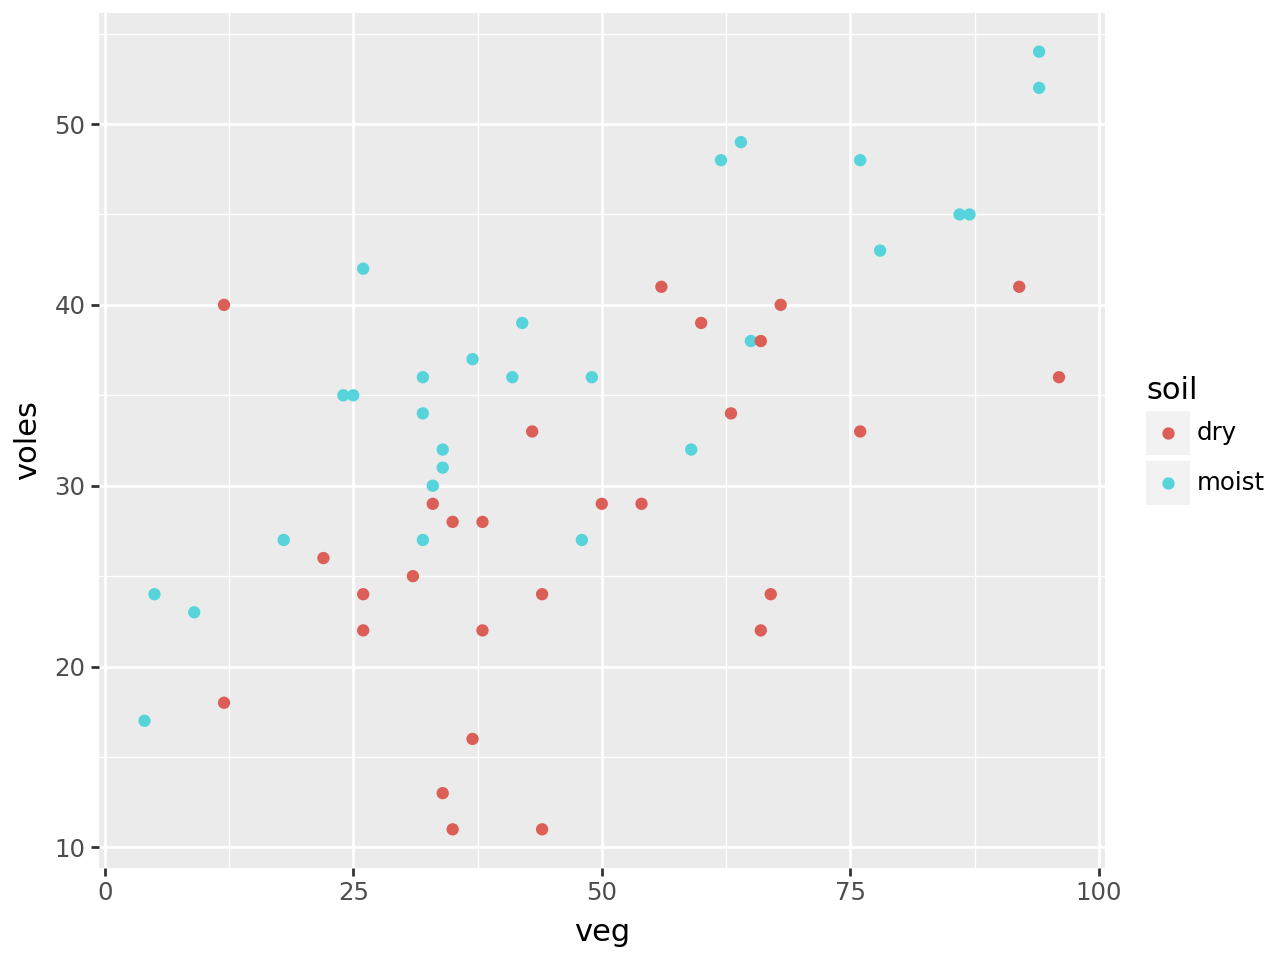

In [16]:
ggplot(df_voles, aes(x='veg', y='voles', color='soil')) + \
    geom_point()

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [17]:
# 1. Make a column transformer
column_trans = make_column_transformer(
    (OneHotEncoder(drop="first"), ['soil']),
    ('passthrough', ['veg'])
)

# 2. Create a pipeline
model_pipeline = make_pipeline(
    column_trans,
    LinearRegression()
)

# 3. Get X (training data) and y predictor from df_voles
X = df_voles[['soil', 'veg']]
y = df_voles['voles']

# 4. Fit the model
model_pipeline.fit(X, y)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil']),
                                                 ('passthrough', 'passthrough',
                                                  ['veg'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [18]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [19]:
regression_table = get_regression_table(model_pipeline)
print(regression_table)

                        term   estimate
0  onehotencoder__soil_moist   9.100298
1           passthrough__veg   0.259069
2                  intercept  15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

Both the visual representation in the chart and the positive regression coefficient for veg strongly suggest that more vegetation cover is associated with higher vole populations. Therefore, protecting sites with high vegetation cover would likely lead to a greater preservation of the vole population.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

To support a population of about 30 voles on dry sites,
they need to maintain approximately 56.11% vegetation cover.


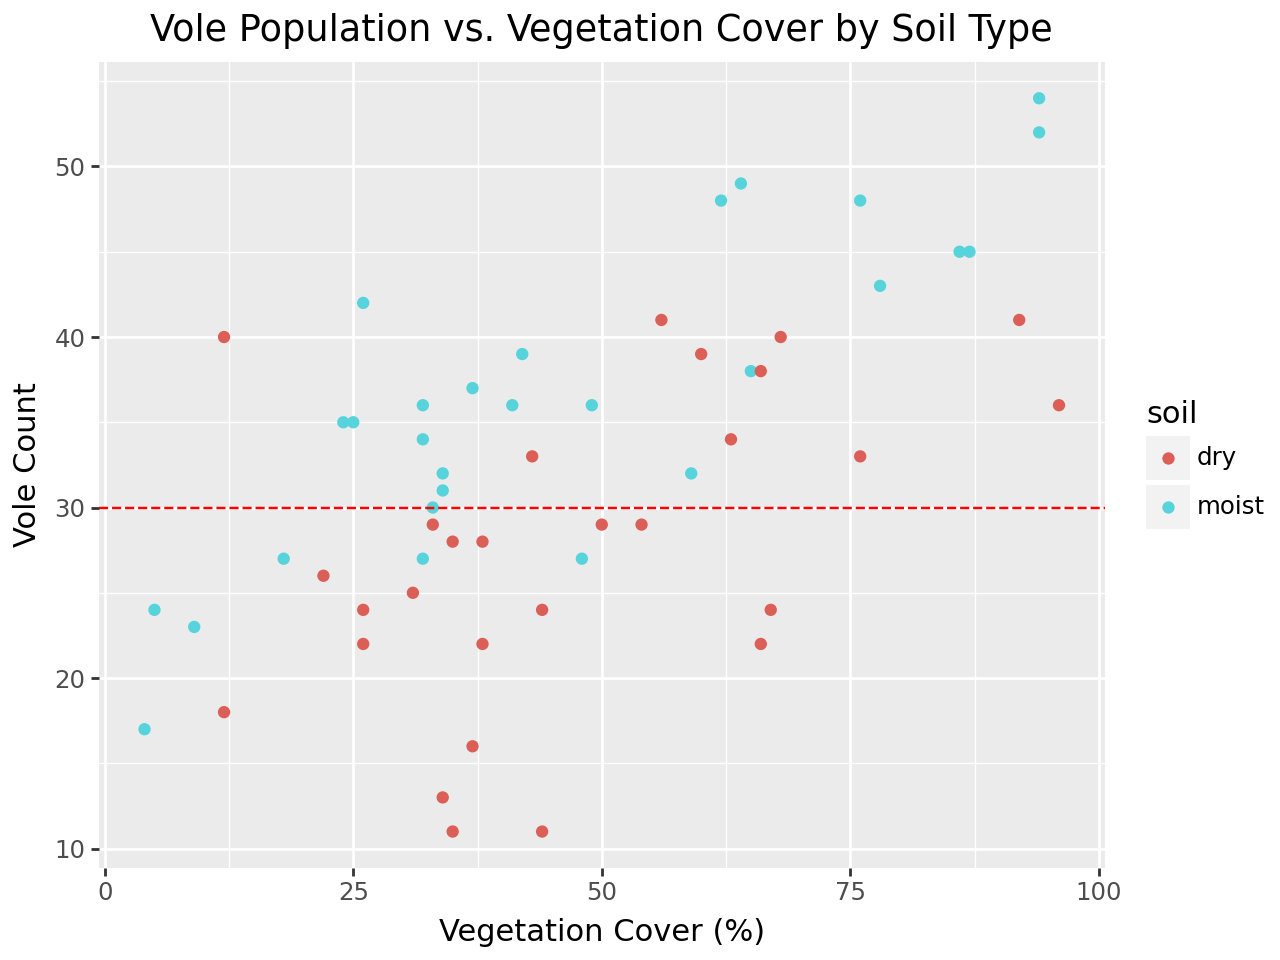

In [20]:
linear_model = model_pipeline.named_steps['linearregression']


feature_names_out = model_pipeline.named_steps['columntransformer'].get_feature_names_out()

# Create a mapping from transformed feature name to its coefficient
coef_dict = dict(zip(feature_names_out, linear_model.coef_))

# Intercept of the model
intercept = linear_model.intercept_

# Target vole population
target_voles = 30



veg_coef = coef_dict['passthrough__veg']

# The equation for dry sites is:
# target_voles = intercept + (veg_coef * veg)
# Solve for veg:
# veg = (target_voles - intercept) / veg_coef

required_veg_cover = (target_voles - intercept) / veg_coef

print(f"To support a population of about {target_voles} voles on dry sites,")
print(f"they need to maintain approximately {required_veg_cover:.2f}% vegetation cover.")


# Create the plot with the added horizontal line
ggplot(df_voles, aes(x='veg', y='voles', color='soil')) + \
    geom_point() + \
    geom_hline(yintercept=30, linetype='dashed', color='red') + \
    labs(
        title="Vole Population vs. Vegetation Cover by Soil Type",
        x="Vegetation Cover (%)",
        y="Vole Count"
    )

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

In [21]:
# Define the characteristics of the new site
new_site_data = pd.DataFrame({
    "soil": ["moist"],
    "veg": [40]
})

# Use the pipeline's predict method
predicted_voles = model_pipeline.predict(new_site_data)

print(f"For a site with moist soil and 40% vegetation cover, the predicted vole population is approximately: {predicted_voles[0]:.2f} voles.")

For a site with moist soil and 40% vegetation cover, the predicted vole population is approximately: 34.93 voles.
